In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rc
import matplotlib.pyplot as plt 
rc('font',family='Malgun Gothic') # 한글
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호

import os
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.core.display import HTML
import time
import re

# <font color=red>__데이터 불러오기__</font>

In [ ]:
# 파일 불러와서 변수에 저장
path = './dataset'
file_list = os.listdir(path)

data_li = []
for file in file_list:
    data = pd.read_csv(f'dataset/{file}',encoding='cp949')
    file_name = file.replace('.txt','')
    globals()[file_name] = data
    data_li.append(file_name)

In [ ]:
# purprd 구매일자 type 변경 및 년, 반기, 분기, 요일 추가
purprd['구매일자'] = pd.to_datetime(purprd['구매일자'], format='%Y%m%d')
purprd['year'] = purprd['구매일자'].dt.year
purprd['quarter'] = purprd['구매일자'].dt.quarter
purprd['weekday'] = purprd['구매일자'].dt.weekday # 월 0 ~ 일 6

def to_half(year,quarter):
    if (year==2014) & (quarter in [1,2]):
        return 1
    elif (year==2014) & (quarter in [3,4]):
        return 2
    elif (year==2015) & (quarter in [1,2]):
        return 3
    else:
        return 4
        
purprd['half'] = purprd.apply(lambda x: to_half(x['year'], x['quarter']), axis=1)

In [ ]:
# 기존고객 => 매 분기 1회 이상 구매한 고객으로 한정
# 기존고객만 남긴 dataframe 생성
all_cust = pd.pivot_table(purprd,
                         index='고객번호',
                         columns='half',
                         values='구매금액',
                         aggfunc='sum')

existing_cust_idx = all_cust.dropna().index.tolist() # 기존고객 고객번호

for data in data_li:
    try:
        globals()[data] = globals()[data].query(f'고객번호 == {existing_cust_idx}')
    except:
        pass

In [ ]:
# 연령대 묶어줌
def cat_age(age):
    if age == '19세이하':
        return 10
    elif age in ['20세~24세', '25세~29세']:
        return 20
    elif age in ['30세~34세', '35세~39세']:
        return 30
    elif age in ['40세~44세', '45세~49세']:
        return 40
    elif age in ['50세~54세', '55세~59세']:
        return 50
    else:
        return 60
    
cust['연령대'] = cust['연령대'].apply(lambda x: cat_age(x))

# <font color=red>__종속변수__</font>

In [ ]:
# 종속변수
def get_label(p1, p2):
    """
    전체 매출 증감율을 고려한 고객별 매출 증감율(반기 기준)
    -> 감소고객 : 1
    -> 증가고객 : 0
    """
    sales = pd.pivot_table(purprd,index='고객번호', # 고객별 반기 매출
                              columns = 'half',
                              values = '구매금액',
                              aggfunc= 'sum')
    rate_variation = (sum(sales[int(p2)])-sum(sales[int(p1)]))/sum(sales[int(p1)]) # 전체 매출 증감율
    sales[f'y'] = (sales[int(p2)] - sales[int(p1)])/sales[int(p1)]/rate_variation # 고객별 매출 증감율
    
    def to_label(sales_variation): # 매출 감소 고객 : 1
        if sales_variation >= 0:
            return 0
        else:
            return 1
    
    sales[f'y'] = sales[f'y'].apply(lambda x: to_label(x))
    sales = sales[[f'y']]
    return sales

# <font color=red>__독립변수__</font>

# 1) membership

In [ ]:
# membership 가입 개수
def membership_count():
    membership_cust = pd.pivot_table(membership,
                                      index='고객번호',
                                      columns='멤버십명',
                                      values='가입년월',
                                      aggfunc='count').fillna(0)
    membership_cust['가입개수'] = membership_cust.sum(axis=1)
    return membership_cust[['가입개수']]

In [ ]:
# 최초 membership 가입년도
def membership_date():
    membership['가입년월'] = pd.to_datetime(membership['가입년월'], format='%Y%m')
    membership['가입년도'] = membership['가입년월'].dt.year

    first_membership_date = pd.pivot_table(membership,
                                    index='고객번호',
                                    values='가입년도',
                                    aggfunc='min')
    return first_membership_date

# 2) channel

In [ ]:
# app login 횟수
def app_count():
    channel_count = pd.pivot_table(channel,
                  index='고객번호',
                  columns='제휴사',
                  values='이용횟수')

    channel_count['APP로그인횟수'] = channel_count[channel_count.columns[channel_count.columns.str.contains('APP')]].sum(axis=1)
    return channel_count[['APP로그인횟수']]

# 3) compuse

In [ ]:
# B제휴사 경쟁사 이용률
def B_compuse_rate():
    compuse_count = pd.pivot_table(compuse,
                    index='고객번호',
                    columns='경쟁사',
                    values='제휴사',
                    aggfunc='count').fillna(0)
    compuse_count['c_B'] = compuse_count['B01'] + compuse_count['B02']

    purprd_count = pd.pivot_table(purprd.drop_duplicates(subset='영수증번호'),
                                  index='고객번호',
                                  columns='제휴사',
                                  values='영수증번호',
                                  aggfunc='count').fillna(0)

    compuse_count = compuse_count.join(purprd_count)

    compuse_count[f'c_B_rate'] = round(compuse_count['c_B']/(compuse_count['c_B']+compuse_count['B'])*100, 2)
    return compuse_count[['c_B_rate']]

#### prodcat

In [ ]:
# 상품분류 - 대분류, 구매목적분류 추가(수작업)
cat_name = pd.read_excel('상품분류.xlsx', index_col=0)[['소분류코드','대분류','구매목적분류']]
prodcat = pd.merge(prodcat, cat_name, on=['소분류코드'])
purprd = pd.merge(purprd, prodcat[['소분류코드','중분류명','소분류명','대분류','구매목적분류']])

# 4) purprd

In [ ]:
### 비율 계산
def to_rate(df, name):
    total = df.sum(axis=1)
    for col in df.columns:
        df[f'{col}_{name}_rate'] = round(df[col]/total*100, 2)
        df.drop(col, axis=1, inplace=True)
    return df

In [ ]:
# 선매품, 편의품 구매금액 비중
def purpose_cat_amount(p1, p2):
    purpose_cat = pd.pivot_table(purprd.query(f'half==[{p1},{p2}]'),
                                      index='고객번호',
                                      columns='구매목적분류',
                                      values='구매금액',
                                      aggfunc='sum').fillna(0)
    to_rate(purpose_cat, 'amount')

    purpose_cat.drop('전문품_amount_rate',axis=1,inplace=True)
    return purpose_cat

In [ ]:
# 대분류별 구매횟수 비중
def major_cat_count(p1, p2):
    major_cat_count = pd.pivot_table(purprd.query(f'half==[{p1},{p2}]'),
                                      index='고객번호',
                                      columns='대분류',
                                      values='구매금액',
                                      aggfunc='count').fillna(0)

    to_rate(major_cat_count, 'count')
    return major_cat_count[['스포츠레저_count_rate','패션잡화_count_rate',\
                    '의류_count_rate','인테리어_count_rate']]

In [ ]:
# 대분류별 구매금액 비중
def major_cat_amount(p1, p2):
    major_cat_amount = pd.pivot_table(purprd.query(f'half==[{p1},{p2}]'),
                                      index='고객번호',
                                      columns='대분류',
                                      values='구매금액',
                                      aggfunc='sum').fillna(0)

    to_rate(major_cat_amount, 'amount')
    return major_cat_amount[['가공식품_amount_rate','일상용품_amount_rate']]

In [ ]:
# 제휴사별 구매횟수 비중
def affiliate_count(p1, p2):
    affiliate_count = pd.pivot_table(purprd.query(f'half==[{p1},{p2}]'),
                                      index='고객번호',
                                      columns='제휴사',
                                      values='구매금액',
                                      aggfunc='count').fillna(0)
    to_rate(affiliate_count, 'count')
#     return affiliate_count
    return affiliate_count['A_count_rate']

In [ ]:
# 제휴사별 구매금액 비중
def affiliate_mount(p1, p2):
    affiliate_mount = pd.pivot_table(purprd.query(f'half==[{p1},{p2}]'),
                                      index='고객번호',
                                      columns='제휴사',
                                      values='구매금액',
                                      aggfunc='sum').fillna(0)
    to_rate(affiliate_mount, 'mount')
#     return affiliate_mount
    return affiliate_mount['A_mount_rate']

In [ ]:
### 증감율 계산(purprd, 구매금액 기준)
def purprd_amount_pv(col, period1, period2):
    for i in [period1, period2]:
        globals()[f'p{i}'] = pd.pivot_table(purprd.query(f'half=={i}'),
                                           index='고객번호',
                                           columns=col,
                                           values='구매금액',
                                           aggfunc='sum').fillna(0)
        
    variation = (globals()[f'p{period2}'] - globals()[f'p{period1}'])/globals()[f'p{period1}']*100
    return variation.replace({np.inf:100, np.nan:0})

# <font color=red>__dataset__</font>

In [ ]:
def make_dataset(p1, p2, p3):
    dataset = pd.DataFrame(get_label(p1, p3)).join([ # 종속변수
        B_compuse_rate(), # B제휴사 경쟁사 이용률                            
        purpose_cat_amount(p1, p2), # 선매품, 편의품 구매금액 비중           
        major_cat_count(p1, p2), # 대분류별 구매횟수 비중(스포츠레저,패션잡화,의류,인테리어) 
        major_cat_amount(p1, p2), # 대분류별 구매금액 비중(가공식품,일상용품)
        affiliate_count(p1, p2), # 제휴사별 구매횟수 비중(A)
        affiliate_mount(p1, p2), # 제휴사별 구매금액 비중(A)
        purprd_amount_pv('구매목적분류', p1, p2)[['편의품']], # 편의품 구매금액 증감율
        purprd_amount_pv('대분류', p1, p2)[['가공식품','미용품','스포츠레저','의류']], # 대분류별 구매금액 증감율
        purprd_amount_pv('제휴사', p1, p2)[['A']], # 제휴사별 구매금액 증감율
        purprd_amount_pv(None,p1, p2) # 구매금액 증감율
        ])
    dataset.fillna(0, inplace=True)
    return dataset

dataset1 = make_dataset(1,2,3)
dataset2 = make_dataset(2,3,4)

In [ ]:
dataset1.to_csv('test/dataset1_test.csv')
dataset2.to_csv('test/dataset2_test.csv')

# <font color=red>__machin learning__</font>

In [ ]:
dataset1 = pd.read_csv('test/dataset1_test.csv', index_col=0)
dataset2 = pd.read_csv('test/dataset2_test.csv', index_col=0)

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset1.drop('y', axis=1)
y = dataset1['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=1004)

# ========================  최종 TEST시 사용  ========================

# X_train = dataset1.drop('y', axis=1)
# y_train = dataset1['y']

# X_test = dataset2.drop('y', axis=1)
# y_test = dataset2['y']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
# from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# 객체 생성
dct_clf = DecisionTreeClassifier(criterion = 'entropy')
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()
xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()
gb_clf = GradientBoostingClassifier()
# svm_clf = SVC(probability=True)

# 파라미터 설정
dct_parameters = {'max_depth':[3,5], }
rf_parameters = {'n_estimators':[100,200,300], 'max_depth':[7,9,11]}
lr_parameters = { "penalty":['l1', 'l2', 'elasticnet', 'none'], 'C': [ 1, 10, 100, 1000]}
xgb_parameters = {'n_estimators':[300], 'learning_rate':[0.05, 0.1], 'max_depth':[4,5,6]}
lgb_parameters = {'n_estimators':[300], 'learning_rate':[0.05, 0.1], 'max_depth':[4,5,6]}
gb_parameters = {'n_estimators':[100,200,300,400,500],'learning_rate':[0.05,0.1]}
# svm_parameters = {'kernel':['linear', 'rbf'], 'C':[2,4,6,8,10]}

clf_param = [(dct_clf,dct_parameters),(rf_clf,rf_parameters),(lr_clf,lr_parameters),
             (xgb_clf,xgb_parameters),(lgb_clf,lgb_parameters),(gb_clf,gb_parameters),
             ] # , (svm_clf,svm_parameters)

for clf, parameter in clf_param:
    grid_clf = GridSearchCV(clf, param_grid=parameter, scoring='accuracy', cv=3, refit=True)
    grid_clf.fit(X_train, y_train)
    
    # 교차검증 결과 출력
    class_name = clf.__class__.__name__
    scores_df = pd.DataFrame(grid_clf.cv_results_)
    display(HTML(scores_df[['params','rank_test_score','mean_test_score']].to_html()))
    print(f'{class_name} 최적 하이퍼 파라미터:', grid_clf.best_params_)
    print('{0} 최고 정확도:{1:.4f}'.format(class_name,grid_clf.best_score_))
    
    # x_test에 최적 하이퍼 파라미터 적용하여 분석한 결과
    best_clf = grid_clf.best_estimator_
    pred = best_clf.predict(X_test)
    pred_proba = best_clf.predict_proba(X_test)[:,1]
    print('테스트 데이터 세트 정확도:{:.4f}'.format(accuracy_score(y_test,pred)))

,params,rank_test_score,mean_test_score
0,{'max_depth': 3},1,0.707581
1,{'max_depth': 5},2,0.702955


DecisionTreeClassifier 최적 하이퍼 파라미터: {'max_depth': 3}
DecisionTreeClassifier 최고 정확도:0.7076
테스트 데이터 세트 정확도:0.7175


,params,rank_test_score,mean_test_score
0,"{'max_depth': 7, 'n_estimators': 100}",5,0.713998
1,"{'max_depth': 7, 'n_estimators': 200}",1,0.715267
2,"{'max_depth': 7, 'n_estimators': 300}",3,0.714222
3,"{'max_depth': 9, 'n_estimators': 100}",2,0.715118
4,"{'max_depth': 9, 'n_estimators': 200}",9,0.712580
5,"{'max_depth': 9, 'n_estimators': 300}",6,0.713998
6,"{'max_depth': 11, 'n_estimators': 100}",4,0.714147
7,"{'max_depth': 11, 'n_estimators': 200}",7,0.713327
8,"{'max_depth': 11, 'n_estimators': 300}",8,0.713177


RandomForestClassifier 최적 하이퍼 파라미터: {'max_depth': 7, 'n_estimators': 200}
RandomForestClassifier 최고 정확도:0.7153
테스트 데이터 세트 정확도:0.7199


,params,rank_test_score,mean_test_score
0,"{'C': 1, 'penalty': 'l1'}",9,NaN
1,"{'C': 1, 'penalty': 'l2'}",1,0.713551
2,"{'C': 1, 'penalty': 'elasticnet'}",10,NaN
3,"{'C': 1, 'penalty': 'none'}",2,0.713252
4,"{'C': 10, 'penalty': 'l1'}",11,NaN
5,"{'C': 10, 'penalty': 'l2'}",7,0.712804
6,"{'C': 10, 'penalty': 'elasticnet'}",12,NaN
7,"{'C': 10, 'penalty': 'none'}",2,0.713252
8,"{'C': 100, 'penalty': 'l1'}",13,NaN
9,"{'C': 100, 'penalty': 'l2'}",6,0.712954


LogisticRegression 최적 하이퍼 파라미터: {'C': 1, 'penalty': 'l2'}
LogisticRegression 최고 정확도:0.7136
테스트 데이터 세트 정확도:0.7140
[13:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric 

,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}",1,0.709521
1,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}",2,0.705492
2,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}",4,0.703626
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}",3,0.703999
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",5,0.699075
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}",6,0.695344


XGBClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
XGBClassifier 최고 정확도:0.7095
테스트 데이터 세트 정확도:0.7104


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}",1,0.706313
1,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}",2,0.705044
2,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}",3,0.701985
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}",4,0.700269
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",5,0.697657
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}",6,0.694374


LGBMClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
LGBMClassifier 최고 정확도:0.7063
테스트 데이터 세트 정확도:0.7121


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'n_estimators': 100}",1,0.715118
1,"{'learning_rate': 0.05, 'n_estimators': 200}",2,0.714222
2,"{'learning_rate': 0.05, 'n_estimators': 300}",5,0.709521
3,"{'learning_rate': 0.05, 'n_estimators': 400}",8,0.707805
4,"{'learning_rate': 0.05, 'n_estimators': 500}",4,0.709894
5,"{'learning_rate': 0.1, 'n_estimators': 100}",3,0.712804
6,"{'learning_rate': 0.1, 'n_estimators': 200}",6,0.709223
7,"{'learning_rate': 0.1, 'n_estimators': 300}",7,0.707879
8,"{'learning_rate': 0.1, 'n_estimators': 400}",9,0.706312
9,"{'learning_rate': 0.1, 'n_estimators': 500}",10,0.703328


GradientBoostingClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'n_estimators': 100}
GradientBoostingClassifier 최고 정확도:0.7151
테스트 데이터 세트 정확도:0.7173


[13:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

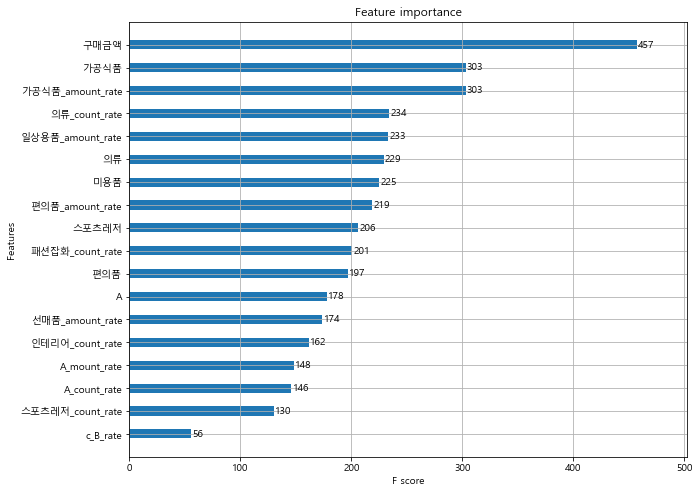

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

xgb_clf = XGBClassifier(learning_rate=0.05, max_depth=4, n_estimators=300)
xgb_clf.fit(X_train, y_train)
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [ ]:
import winsound as sd
def beep():
    fr = 2000; du = 1000
    sd.Beep(fr, du)
beep()

# <font color=red>__아노바분석🤖__</font>

In [ ]:
# # anova pvalue 함수👻`
from scipy import stats

def anova_test(dataset):
    num = 1
    target = dataset.y
    data = dataset.drop('y',axis=1).join(target)
    
    for n in range(len(data.columns[:-1])):
        grps = [data[data.columns[-1]].tolist() for _, data in data.groupby(data.columns[n])]        
        F, p = stats.f_oneway(*grps)
        if p >= 0.05:
            print(num, data.columns[n],':', round(p,3),'무의미')
        if p < 0.05:
            print(num, data.columns[n],':', round(p,3),'😊')
        num += 1
            
anova_test(dataset1)

# 연습장

In [ ]:
%cd /content/drive/MyDrive/Cakd3_Project/1.ldata_현정/test

/content/drive/MyDrive/Cakd3_Project/1.ldata_현정/test


In [ ]:
dataset1 = pd.read_csv('dataset1_test.csv', index_col=0)
dataset2 = pd.read_csv('dataset2_test.csv', index_col=0)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def clf(train, test=None):
    
    if test is not None:
        mode = '테스트'
        X_train = train.drop('y', axis=1)
        y_train = train['y']

        X_test = test.drop('y', axis=1)
        y_test = test['y']
        
    else:
        mode = '검증'
        X = train.drop('y', axis=1)
        y = train['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                           test_size=0.3,
                                                           random_state=1004)

    # 객체 생성
    dct_clf = DecisionTreeClassifier(criterion = 'entropy')
    rf_clf = RandomForestClassifier()
    lr_clf = LogisticRegression()
    xgb_clf = XGBClassifier()
    lgb_clf = LGBMClassifier()
    gb_clf = GradientBoostingClassifier()
    # svm_clf = SVC(probability=True)

    # 파라미터 설정
    dct_parameters = {'max_depth':[3,5], }
    rf_parameters = {'n_estimators':[100,200,300], 'max_depth':[7,9,11]}
    lr_parameters = { "penalty":['l1', 'l2', 'elasticnet', 'none'], 'C': [ 1, 10, 100, 1000]}
    xgb_parameters = {'n_estimators':[300], 'learning_rate':[0.05, 0.1], 'max_depth':[4,5,6]}
    lgb_parameters = {'n_estimators':[300], 'learning_rate':[0.05, 0.1], 'max_depth':[4,5,6]}
    gb_parameters = {'n_estimators':[100,200,300,400,500],'learning_rate':[0.05,0.1]}
    # svm_parameters = {'kernel':['linear', 'rbf'], 'C':[2,4,6,8,10]}

    clf_param = [(dct_clf,dct_parameters),(rf_clf,rf_parameters),(lr_clf,lr_parameters),
                 (xgb_clf,xgb_parameters),(lgb_clf,lgb_parameters),(gb_clf,gb_parameters),
                 ] # , (svm_clf,svm_parameters)

    for clf, parameter in clf_param:
        grid_clf = GridSearchCV(clf, param_grid=parameter, scoring='accuracy', cv=3, refit=True)
        grid_clf.fit(X_train, y_train)

        # 교차검증 결과 출력
        class_name = clf.__class__.__name__
        scores_df = pd.DataFrame(grid_clf.cv_results_)
        display(HTML(scores_df[['params','rank_test_score','mean_test_score']].to_html()))
        print(f'{class_name} 최적 하이퍼 파라미터:', grid_clf.best_params_)
        print('{0} 최고 정확도:{1:.4f}'.format(class_name,grid_clf.best_score_))

        # x_test에 최적 하이퍼 파라미터 적용하여 분석한 결과
        best_clf = grid_clf.best_estimator_
        pred = best_clf.predict(X_test)
        pred_proba = best_clf.predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        auc = roc_auc_score(y_test, pred_proba)

        print(f'< {mode} 데이터셋 >')
        print('accuracy  :  {:.4f}'.format(accuracy))
        print('precision :  {:.4f}'.format(precision))
        print('recall    :  {:.4f}'.format(recall))
        print('f1        :  {:.4f}\n'.format(f1))
        print('roc_auc   :  {:.4f}'.format(auc))

In [36]:
clf(dataset1)

,params,rank_test_score,mean_test_score
0,{'max_depth': 3},1,0.707581
1,{'max_depth': 5},2,0.702955


DecisionTreeClassifier 최적 하이퍼 파라미터: {'max_depth': 3}
DecisionTreeClassifier 최고 정확도:0.7076
< 검증 데이터셋 >
accuracy  :  0.7175
precision :  0.6678
recall    :  0.6459
f1        :  0.6567

roc_auc   :  0.7705


,params,rank_test_score,mean_test_score
0,"{'max_depth': 7, 'n_estimators': 100}",4,0.713476
1,"{'max_depth': 7, 'n_estimators': 200}",1,0.715192
2,"{'max_depth': 7, 'n_estimators': 300}",3,0.713924
3,"{'max_depth': 9, 'n_estimators': 100}",7,0.712282
4,"{'max_depth': 9, 'n_estimators': 200}",8,0.711611
5,"{'max_depth': 9, 'n_estimators': 300}",6,0.713103
6,"{'max_depth': 11, 'n_estimators': 100}",9,0.710193
7,"{'max_depth': 11, 'n_estimators': 200}",5,0.713177
8,"{'max_depth': 11, 'n_estimators': 300}",2,0.714073


RandomForestClassifier 최적 하이퍼 파라미터: {'max_depth': 7, 'n_estimators': 200}
RandomForestClassifier 최고 정확도:0.7152
< 검증 데이터셋 >
accuracy  :  0.7187
precision :  0.6718
recall    :  0.6404
f1        :  0.6557

roc_auc   :  0.7849


,params,rank_test_score,mean_test_score
0,"{'C': 1, 'penalty': 'l1'}",9,NaN
1,"{'C': 1, 'penalty': 'l2'}",1,0.713551
2,"{'C': 1, 'penalty': 'elasticnet'}",10,NaN
3,"{'C': 1, 'penalty': 'none'}",2,0.713178
4,"{'C': 10, 'penalty': 'l1'}",11,NaN
5,"{'C': 10, 'penalty': 'l2'}",7,0.712804
6,"{'C': 10, 'penalty': 'elasticnet'}",12,NaN
7,"{'C': 10, 'penalty': 'none'}",2,0.713178
8,"{'C': 100, 'penalty': 'l1'}",13,NaN
9,"{'C': 100, 'penalty': 'l2'}",6,0.712954


LogisticRegression 최적 하이퍼 파라미터: {'C': 1, 'penalty': 'l2'}
LogisticRegression 최고 정확도:0.7136
< 검증 데이터셋 >
accuracy  :  0.7140
precision :  0.6707
recall    :  0.6213
f1        :  0.6451

roc_auc   :  0.7759


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}",1,0.709521
1,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}",2,0.705492
2,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}",4,0.703626
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}",3,0.703999
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",5,0.699075
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}",6,0.695344


XGBClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
XGBClassifier 최고 정확도:0.7095
< 검증 데이터셋 >
accuracy  :  0.7104
precision :  0.6565
recall    :  0.6450
f1        :  0.6507

roc_auc   :  0.7840


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}",1,0.710118
1,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}",3,0.705268
2,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}",4,0.704522
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}",2,0.706163
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",5,0.699448
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}",6,0.697135


LGBMClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
LGBMClassifier 최고 정확도:0.7101
< 검증 데이터셋 >
accuracy  :  0.7107
precision :  0.6588
recall    :  0.6396
f1        :  0.6491

roc_auc   :  0.7824


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'n_estimators': 100}",1,0.715118
1,"{'learning_rate': 0.05, 'n_estimators': 200}",2,0.714297
2,"{'learning_rate': 0.05, 'n_estimators': 300}",5,0.709745
3,"{'learning_rate': 0.05, 'n_estimators': 400}",8,0.707730
4,"{'learning_rate': 0.05, 'n_estimators': 500}",4,0.710118
5,"{'learning_rate': 0.1, 'n_estimators': 100}",3,0.712879
6,"{'learning_rate': 0.1, 'n_estimators': 200}",6,0.709297
7,"{'learning_rate': 0.1, 'n_estimators': 300}",7,0.708029
8,"{'learning_rate': 0.1, 'n_estimators': 400}",9,0.706238
9,"{'learning_rate': 0.1, 'n_estimators': 500}",10,0.703104


GradientBoostingClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'n_estimators': 100}
GradientBoostingClassifier 최고 정확도:0.7151
< 검증 데이터셋 >
accuracy  :  0.7175
precision :  0.6681
recall    :  0.6450
f1        :  0.6564

roc_auc   :  0.7844


In [37]:
clf(dataset1, dataset2)

,params,rank_test_score,mean_test_score
0,{'max_depth': 3},1,0.708519
1,{'max_depth': 5},2,0.705646


DecisionTreeClassifier 최적 하이퍼 파라미터: {'max_depth': 3}
DecisionTreeClassifier 최고 정확도:0.7085
< 테스트 데이터셋 >
accuracy  :  0.6956
precision :  0.7228
recall    :  0.6125
f1        :  0.6631

roc_auc   :  0.7586


,params,rank_test_score,mean_test_score
0,"{'max_depth': 7, 'n_estimators': 100}",1,0.714368
1,"{'max_depth': 7, 'n_estimators': 200}",2,0.713115
2,"{'max_depth': 7, 'n_estimators': 300}",3,0.712802
3,"{'max_depth': 9, 'n_estimators': 100}",7,0.712018
4,"{'max_depth': 9, 'n_estimators': 200}",6,0.712227
5,"{'max_depth': 9, 'n_estimators': 300}",8,0.711862
6,"{'max_depth': 11, 'n_estimators': 100}",4,0.712645
7,"{'max_depth': 11, 'n_estimators': 200}",9,0.710608
8,"{'max_depth': 11, 'n_estimators': 300}",5,0.712436


RandomForestClassifier 최적 하이퍼 파라미터: {'max_depth': 7, 'n_estimators': 100}
RandomForestClassifier 최고 정확도:0.7144
< 테스트 데이터셋 >
accuracy  :  0.6984
precision :  0.7001
recall    :  0.6707
f1        :  0.6851

roc_auc   :  0.7680


,params,rank_test_score,mean_test_score
0,"{'C': 1, 'penalty': 'l1'}",9,NaN
1,"{'C': 1, 'penalty': 'l2'}",2,0.709302
2,"{'C': 1, 'penalty': 'elasticnet'}",10,NaN
3,"{'C': 1, 'penalty': 'none'}",3,0.709146
4,"{'C': 10, 'penalty': 'l1'}",11,NaN
5,"{'C': 10, 'penalty': 'l2'}",1,0.709354
6,"{'C': 10, 'penalty': 'elasticnet'}",12,NaN
7,"{'C': 10, 'penalty': 'none'}",3,0.709146
8,"{'C': 100, 'penalty': 'l1'}",13,NaN
9,"{'C': 100, 'penalty': 'l2'}",7,0.709146


LogisticRegression 최적 하이퍼 파라미터: {'C': 10, 'penalty': 'l2'}
LogisticRegression 최고 정확도:0.7094
< 테스트 데이터셋 >
accuracy  :  0.6878
precision :  0.6997
recall    :  0.6337
f1        :  0.6651

roc_auc   :  0.7569


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}",1,0.708989
1,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}",3,0.705542
2,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}",4,0.705020
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}",2,0.707631
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",5,0.701625
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}",6,0.696768


XGBClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
XGBClassifier 최고 정확도:0.7090
< 테스트 데이터셋 >
accuracy  :  0.7001
precision :  0.7001
recall    :  0.6764
f1        :  0.6881

roc_auc   :  0.7685


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}",1,0.710399
1,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}",2,0.707736
2,"{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}",3,0.707579
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}",4,0.704759
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",5,0.702983
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}",6,0.697499


LGBMClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
LGBMClassifier 최고 정확도:0.7104
< 테스트 데이터셋 >
accuracy  :  0.6982
precision :  0.6982
recall    :  0.6745
f1        :  0.6861

roc_auc   :  0.7677


,params,rank_test_score,mean_test_score
0,"{'learning_rate': 0.05, 'n_estimators': 100}",1,0.713011
1,"{'learning_rate': 0.05, 'n_estimators': 200}",2,0.712958
2,"{'learning_rate': 0.05, 'n_estimators': 300}",4,0.711287
3,"{'learning_rate': 0.05, 'n_estimators': 400}",7,0.709929
4,"{'learning_rate': 0.05, 'n_estimators': 500}",8,0.709564
5,"{'learning_rate': 0.1, 'n_estimators': 100}",3,0.712280
6,"{'learning_rate': 0.1, 'n_estimators': 200}",5,0.710034
7,"{'learning_rate': 0.1, 'n_estimators': 300}",6,0.709981
8,"{'learning_rate': 0.1, 'n_estimators': 400}",9,0.707840
9,"{'learning_rate': 0.1, 'n_estimators': 500}",10,0.706639


GradientBoostingClassifier 최적 하이퍼 파라미터: {'learning_rate': 0.05, 'n_estimators': 100}
GradientBoostingClassifier 최고 정확도:0.7130
< 테스트 데이터셋 >
accuracy  :  0.6975
precision :  0.6997
recall    :  0.6683
f1        :  0.6836

roc_auc   :  0.7685
